In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
from sklearn.svm import OneClassSVM
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# 기기 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 데이터 전처리

In [3]:
 # train 데이터 로딩 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

# 이미지 전처리 및 임베딩, 기존데이터는 좌우 반전만 실행
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CustomDataset(csv_file='./train.csv', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

In [4]:
len(train_data)

426

In [5]:
samples = next(iter(train_loader))
samples.shape

torch.Size([32, 3, 224, 224])

### 모델 초기화 및 특징 추출

In [6]:
# EfficientNet 모델 초기화
model = EfficientNet.from_pretrained('efficientnet-b0')
# print(model) # (_fc): Linear(in_features=1280, out_features=1000, bias=True)

Loaded pretrained weights for efficientnet-b0


In [7]:
model.to(device)

model.eval()

# EfficientNet의 마지막 레이어는 이미지 분류를 위한 출력 레이어
# 하지만 특성 추출을 위해서는 해당 출력 레이어를 제외한 나머지 부분만 사용하므로 마지막 레이어 수정 불필요

def extract_features(loader, model):
    features = []
    with torch.no_grad():
        for inputs in loader:  
            inputs = inputs.to(device)
            outputs = model.extract_features(inputs)  # 특징 추출
            features.append(outputs)

    features = torch.cat(features, dim=0)
    return features

train_features = extract_features(train_loader, model)
train_features.shape

torch.Size([426, 1280, 7, 7])

In [8]:
# train_features를 평탄화하여 2차원 배열로 변환

train_features_flat = train_features.reshape(train_features.shape[0], -1)
train_features_flat.shape

torch.Size([426, 62720])

### One-Class SVM 모델 초기화
- 낮은 nu 값 (예: 0.1): 이상치로 간주될 데이터 포인트의 비율을 낮추어 모델이 더 엄격하게 정상 데이터로만을 인식
- 이는 이상치를 식별하는 더 보수적인 모델을 만들지만 이는 실제로는 이상치를 놓치는 위험도 증가

- 높은 nu 값 (예: 0.5): 이상치로 간주될 데이터 포인트의 비율을 높여 모델이 보다 유연하게 정상 데이터와 이상치를 구분
- 이는 일부 이상치를 더 잘 식별할 수 있지만, 정상 데이터로 오인하는 위험도 증가

In [9]:
nu = 0.05  # 이상치 비율로 0.1 또는 0.05와 같은 값을 사용하는 것이 일반적

ocsvm_model = OneClassSVM(nu=nu)

# 모델 훈련
ocsvm_model.fit(train_features_flat)

OneClassSVM(nu=0.05)

- 결정 경계 : 분류 모델에서 클래스를 나누는 선, 평면 또는 경계를 의미하며 모델이 학습한 데이터를 기반으로 클래스 간의 구분을 담당
- 본 프로젝트와 같은 이상, 정상을 위한 이진 분류에서 결정 경계는 두 클래스를 나누는 선을 의미
- 결정 함수(Decision Function) : One-Class SVM 모델에서 사용되는 함수로, 새로운 데이터 포인트가 모델이 학습한 정상적인 데이터 분포에서 멀리 떨어져 있는지를 측정
- 이 함수는 각 데이터 포인트에서 결정 경계까지의 거리를 계산하고, 이 거리를 기반으로 해당 데이터 포인트를 정상 데이터로 간주할지 이상치로 간주할지를 결정
- 결정 함수의 값이 양수이면 해당 데이터 포인트는 정상으로 분류되며, 음수이면 이상치로 분류

In [10]:
# 정상적인 데이터의 특성을 기반으로 한 decision function 값 확인
decision_values = ocsvm_model.decision_function(train_features_flat)

# 학습된 One-Class SVM 모델의 decision function 값 출력
print("Decision function 값:", decision_values)

Decision function 값: [-3.69105864e-04  2.74485057e-04  1.04980912e+00  7.57992212e-01
  1.11509717e+00  2.70269588e-01  6.66981463e-01  8.92337672e-01
  8.68668643e-01  4.30206885e-01  3.77123211e-01  5.28409975e-01
  6.46717529e-01  6.06984370e-01  2.23856131e-01  8.90987205e-01
  1.68374764e-01 -1.32180145e-04  5.54461380e-01  7.62196481e-01
  2.73838245e-01  7.80406199e-01  8.31376495e-01  6.93357932e-01
  5.79937887e-01  1.19850508e+00  9.32752655e-01  6.48321799e-01
  1.30346046e+00  1.04913647e+00 -6.31321398e-02  6.97247379e-01
  4.82719382e-01  5.56474303e-01  9.11571774e-01  1.07468709e+00
  3.87287454e-01  8.02670510e-02  1.07914632e+00  9.50278314e-01
  2.98702909e-01  9.96089285e-01  1.05090590e+00  1.05440385e+00
  2.28260322e-04  2.53781465e-01  6.95198695e-01  6.72572551e-01
  1.93881043e-01  6.57021789e-01  3.46439455e-01  9.56049217e-01
  3.86497104e-01  5.12368235e-01  7.00267502e-01  6.28962750e-01
  2.08769681e-01  1.02998416e+00  1.05807486e+00  6.76959702e-02
 -2.

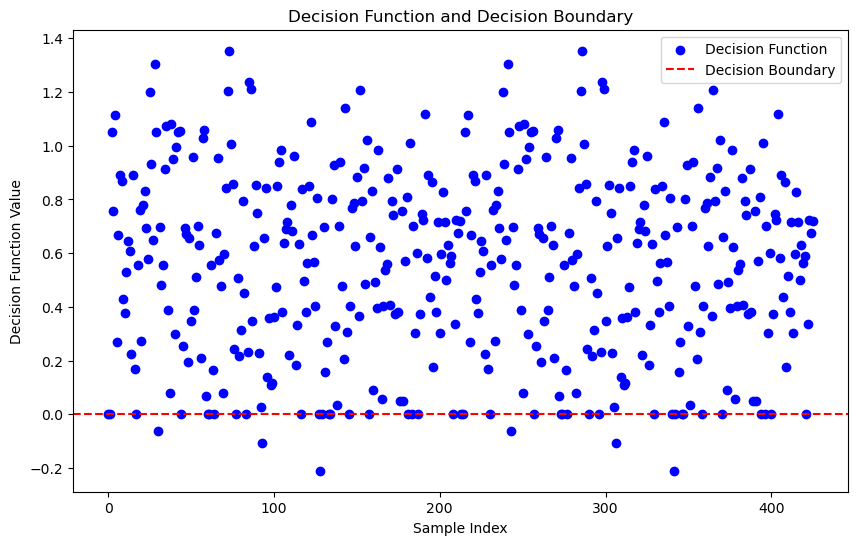

In [11]:
# 결정 함수 값 계산
decision_values = ocsvm_model.decision_function(train_features_flat)

# 결정 함수 값과 결정 경계 시각화
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_values)), decision_values, c='b', label='Decision Function')
plt.axhline(0, color='r', linestyle='--', label='Decision Boundary')
plt.xlabel('Sample Index')
plt.ylabel('Decision Function Value')
plt.title('Decision Function and Decision Boundary')
plt.legend()
plt.show()

### train 확인
- precision : 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율
- recall : 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율

In [12]:
from sklearn.metrics import classification_report

# train 데이터에 대해 추론 수행
train_pred = ocsvm_model.predict(train_features_flat)

# 예측 결과(이상 = -1, 정상 = 1)를 이상 = 1, 정상 = 0으로 변환
train_pred = np.where(train_pred == -1, 1, 0)
train_pred

y_tain_raw = pd.read_csv('./train.csv')
y_train_label = y_tain_raw['label']

print(classification_report(y_train_label, train_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       426
           1       0.00      0.00      0.00         0

    accuracy                           0.94       426
   macro avg       0.50      0.47      0.48       426
weighted avg       1.00      0.94      0.97       426



c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
train_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [14]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , f1_score

print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(y_train_label, train_pred):.4f}')
print(f'재현율 : {recall_score(y_train_label, train_pred):.4f}')
print(f'F1 점수 : {f1_score(y_train_label, train_pred):.4f}')
print(f'정밀도 : {precision_score(y_train_label, train_pred):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.9390
재현율 : 0.0000
F1 점수 : 0.0000
정밀도 : 0.0000


c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


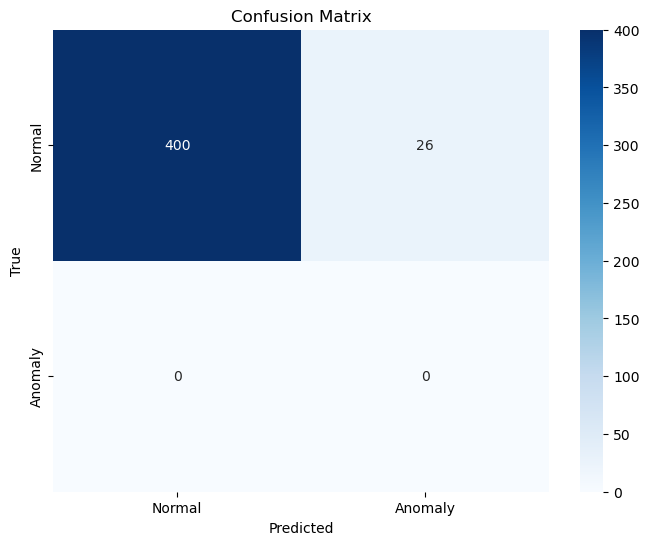

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix 계산
cm = confusion_matrix(y_train_label, train_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### test 확인

In [16]:
# test 데이터 로딩 클래스 정의
class TestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

# 이미지 전처리 및 임베딩
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_data = TestDataset(csv_file='./test_label.csv', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [17]:
len(test_data)

100

In [18]:
samples = next(iter(test_loader))
samples.shape

torch.Size([32, 3, 224, 224])

In [19]:
model.eval()

def extract_features(loader, model):
    features = []
    with torch.no_grad():
        for inputs in loader:  
            inputs = inputs.to(device)
            outputs = model.extract_features(inputs)  # 특징 추출
            features.append(outputs)

    features = torch.cat(features, dim=0)
    return features

test_features = extract_features(test_loader, model)
test_features.shape

torch.Size([100, 1280, 7, 7])

In [20]:
# 특징을 2차원으로 평면화
test_features_flat = test_features.view(test_features.size(0), -1)
test_features_flat.shape

torch.Size([100, 62720])

In [29]:
# test 데이터에 대해 추론 수행
test_pred_features = ocsvm_model.predict(test_features_flat)

# 예측 결과(이상 = -1, 정상 = 1)를 이상 = 1, 정상 = 0으로 변환
test_pred = np.where(test_pred_features == -1, 1, 0)
test_pred

y_test_raw = pd.read_csv('test_label.csv')
y_test_label = y_test_raw['label']

print(classification_report(y_test_label, test_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        61
           1       0.86      0.79      0.83        39

    accuracy                           0.87       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.87      0.87       100



In [30]:
print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(y_test_label, test_pred):.4f}')
print(f'재현율 : {recall_score(y_test_label, test_pred):.4f}')
print(f'F1 점수 : {f1_score(y_test_label, test_pred):.4f}')
print(f'정밀도 : {precision_score(y_test_label, test_pred):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.8700
재현율 : 0.7949
F1 점수 : 0.8267
정밀도 : 0.8611


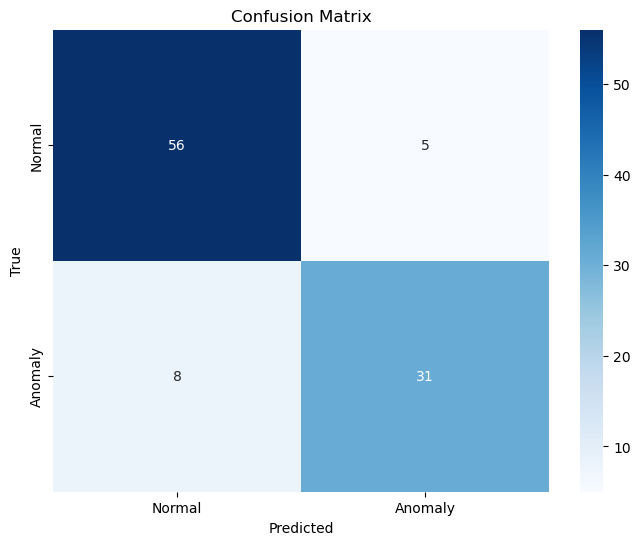

In [31]:
# Confusion Matrix 계산
cm = confusion_matrix(y_test_label, test_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
print(list(y_test_label))

[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]


In [33]:
print(test_pred)

[1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0
 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1]


### 잘못 예측된 이미지 시각화

In [34]:
# 잘못된 예측의 인덱스 찾기
incorrect_indices = np.where(test_pred != y_test_label)[0]
incorrect_indices, len(incorrect_indices)

(array([ 0,  5,  6, 11, 14, 15, 23, 33, 38, 39, 80, 83, 95], dtype=int64), 13)

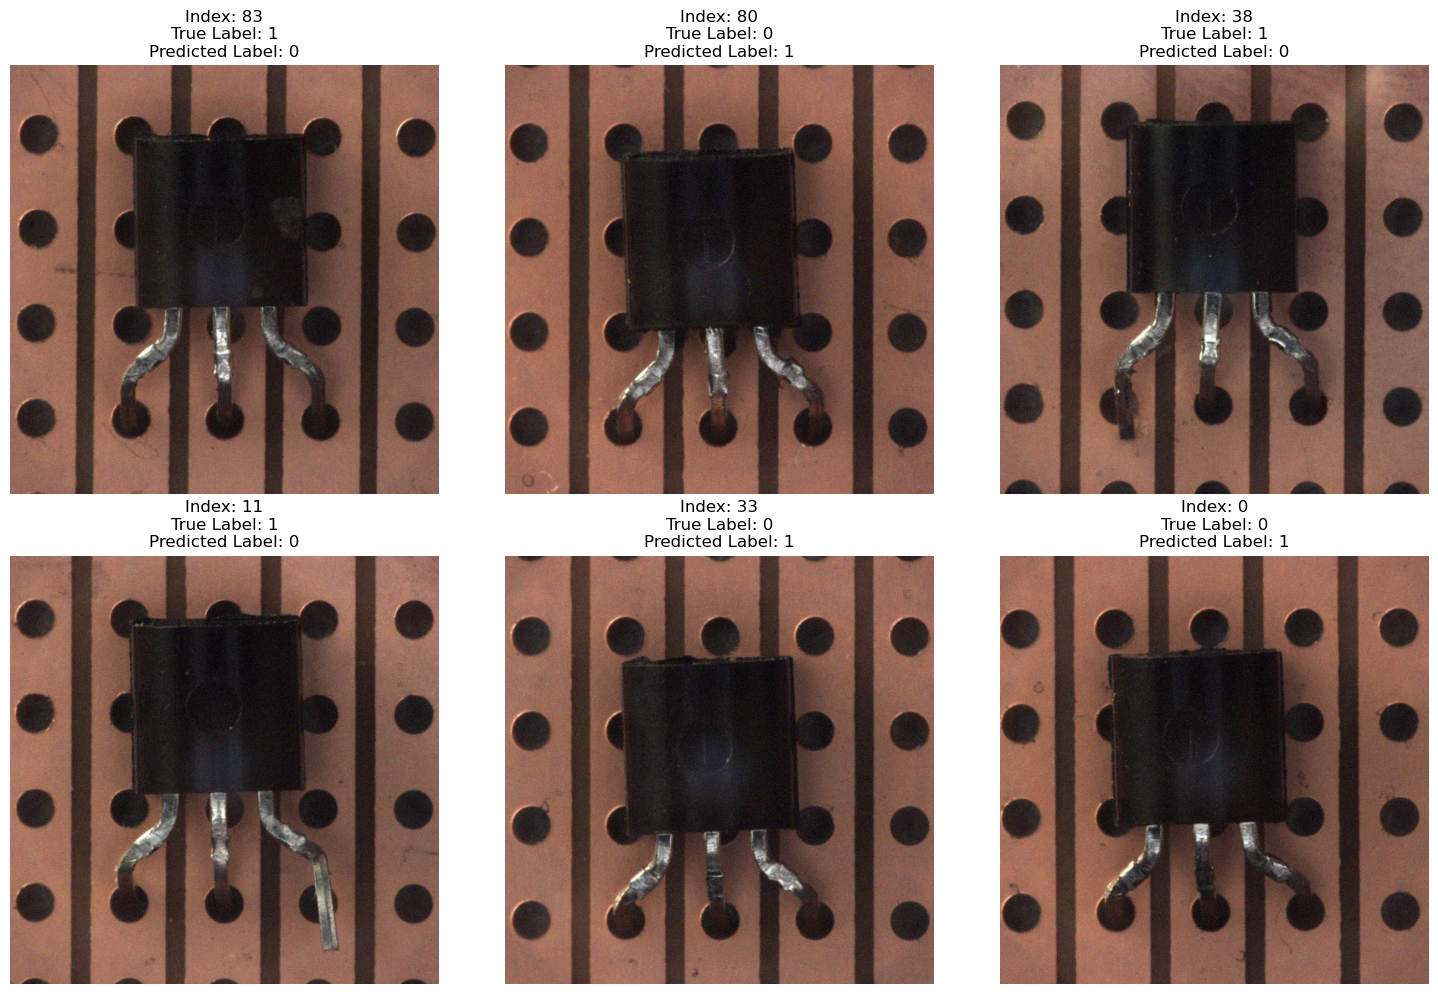

In [35]:
import math

num_images_to_visualize = 6

random_indices = np.random.choice(incorrect_indices, size=min(num_images_to_visualize, len(incorrect_indices)), replace=False)

# 그리드 크기 설정
num_rows = 2
num_cols = 3

# 그리드 생성
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# 이미지를 그리드에 추가
for i, ax in enumerate(axes.flat):
    if i < len(random_indices):
        index = random_indices[i]
        image_path = y_test_raw['img_path'].iloc[index]  # 이미지 경로 가져오기
        image = plt.imread(image_path)  # 이미지 로드하기
        true_label = y_test_label.iloc[index]
        pred_label = test_pred[index]
        ax.imshow(image)
        ax.set_title(f'Index: {index}\nTrue Label: {true_label}\nPredicted Label: {pred_label}')
        ax.axis('off')
    else:
        ax.axis('off')  # 인덱스가 그리드 크기보다 크면 빈 공간 처리

plt.tight_layout()
plt.show()

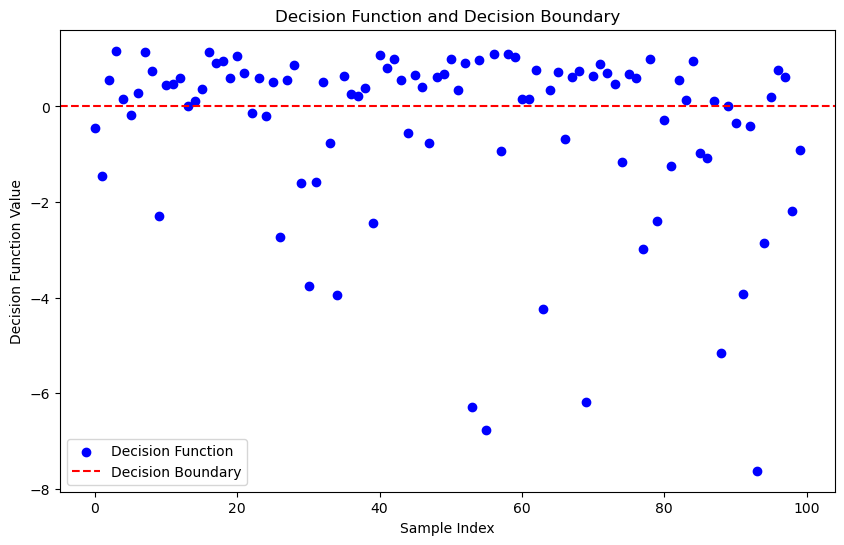

In [39]:
# 결정 함수 값 계산
decision_values = ocsvm_model.decision_function(test_features_flat)

# 결정 함수 값과 결정 경계 시각화
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_values)), decision_values, c='b', label='Decision Function')
plt.axhline(0, color='r', linestyle='--', label='Decision Boundary')
plt.xlabel('Sample Index')
plt.ylabel('Decision Function Value')
plt.title('Decision Function and Decision Boundary')
plt.legend()
plt.show()